## Análise Pedidos Atrasados
- Sua tarefa é ajudar a área de negócios provando a **necessidade de investistimento em uma área de melhoria da experência do cliente ao ter um atraso na entrega**

- Considerações importantes:
   
   - O **time de logística não considera que o atraso na entrega é um problema relevante** e falou que, em média, as entregas estão sendo feitas 10 dias antes do prazo combinado
   
    - Não queremos uma abordagem de: \"nenhuma entrega pode atrasar\". Vamos ser mais tranquilos e seguir na linha de: **\"uma entrega pode atrasar. Como eu posso melhorar a experiência do cliente caso isso aconteça?\"**

#### Para o projeto vou usar o sqlite

In [62]:
#Importando bibliotecas
import sqlite3
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [2]:
#Fazendo a conexão (O banco de dados vendas_db já foi criado)
con = sqlite3.connect('vendas_db.db')

In [3]:
#Criando o cursor
cur = con.cursor()

In [4]:
#Função de consulta SQL
def executa_consulta(consulta):
    resultado = cur.execute(consulta).fetchall()
    resultado = pd.DataFrame(resultado)
    colunas = [i[0] for i in cur.description]
    if resultado.shape[1] > 0:
        resultado.columns = colunas
    display(resultado.head(3))
    return resultado

In [6]:
#Visualizando a tabela de pedidos
pedidos = executa_consulta('SELECT * FROM orders')

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [7]:
#Selecionando colunas específicas onde a entrega JÁ foi feita
pedidos = executa_consulta('SELECT order_id, \
                            order_purchase_timestamp, \
                            order_delivered_customer_date, \
                            order_estimated_delivery_date \
                            FROM orders \
                            WHERE order_delivered_customer_date IS NOT NULL')

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00


In [8]:
#Informações da base
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96476 entries, 0 to 96475
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96476 non-null  object
 1   order_purchase_timestamp       96476 non-null  object
 2   order_delivered_customer_date  96476 non-null  object
 3   order_estimated_delivery_date  96476 non-null  object
dtypes: object(4)
memory usage: 2.9+ MB


In [9]:
#Transformando as colunas que estão como texto em data
datas = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in datas:
    pedidos[i] = pd.to_datetime(pedidos[i], format='%Y-%m-%d %H:%M:%S')

#### Antes de 2017 a empresa ainda estava em momento de teste, então vamos analisar de 2017 para frente quando começou de fato a produção

In [11]:
#Filtrando para pedidos apenas de 2017 para frente
pedidos = pedidos[pedidos.order_purchase_timestamp.dt.year >= 2017]

In [12]:
#Calculando a diferença de dias entre a data estimada e a data entregue
pedidos['dias_atraso'] = (pedidos.order_estimated_delivery_date.dt.date - pedidos.order_delivered_customer_date.dt.date).dt.days

In [14]:
#Informações sobre os dias de atraso
pedidos.dias_atraso.describe()

count    96204.000000
mean        11.807721
std         10.089181
min       -188.000000
25%          7.000000
50%         12.000000
75%         17.000000
max        147.000000
Name: dias_atraso, dtype: float64

In [15]:
#Separando os pedidos em mês e ano
pedidos['mes/ano'] = pedidos.order_purchase_timestamp.dt.to_period('M')

In [16]:
#Testando os indicadores de média, mínimo e máximo
media = pedidos.groupby('mes/ano')['dias_atraso'].mean()
minimo = pedidos.groupby('mes/ano')['dias_atraso'].min()
maximo = pedidos.groupby('mes/ano')['dias_atraso'].max()

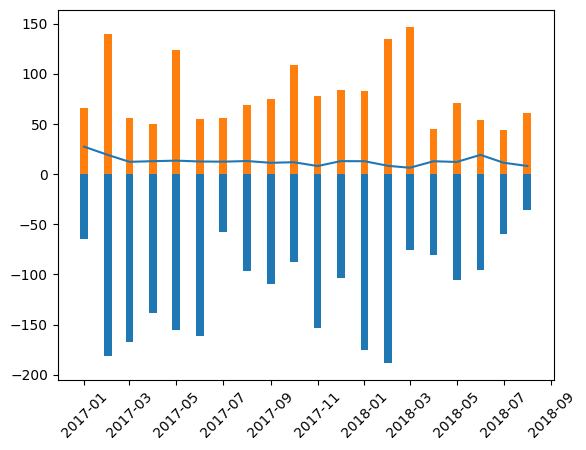

In [18]:
#Visualização dos indicadores
fig, ax = plt.subplots()

ax.plot(media.index.to_timestamp(), media.values)
ax.bar(minimo.index.to_timestamp(), minimo.values, width=10)
ax.bar(maximo.index.to_timestamp(), maximo.values, width=10)

plt.xticks(rotation=45)

plt.show()

#### Podemos definir que a média não seria um bom indicador nesse caso, pois apesar de ter uma média de 10 dias existem pedidos que foram entregues muito antes e pedidos que foram entregues MUITO depois

In [19]:
#Função que indica se um pedido chegou atrasado ou não
pedidos['contagem_atrasados'] = pedidos.dias_atraso.apply(lambda x: 1 if x < 0 else 0)

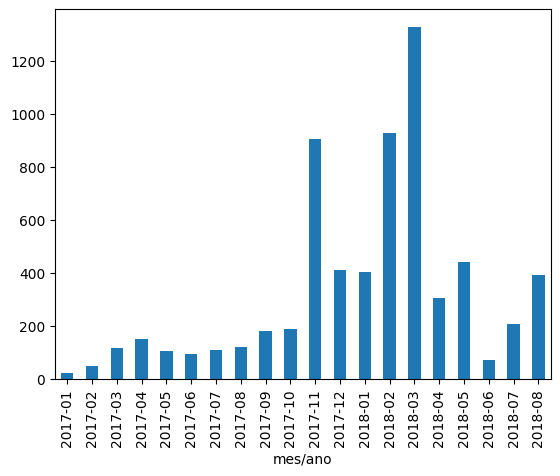

In [21]:
#Calculando a quantidade de pedidos atrasados por mês
pedidos.groupby('mes/ano')['contagem_atrasados'].sum().plot.bar();

In [22]:
#Calculando a proporção de pedidos atrasados em relação aos pedidos realizados
pedidos_atrasados = pedidos.groupby('mes/ano')['contagem_atrasados'].sum()
contagem_pedidos = pedidos.groupby('mes/ano')['contagem_atrasados'].count()
percentual = round((pedidos_atrasados/contagem_pedidos)*100,1)

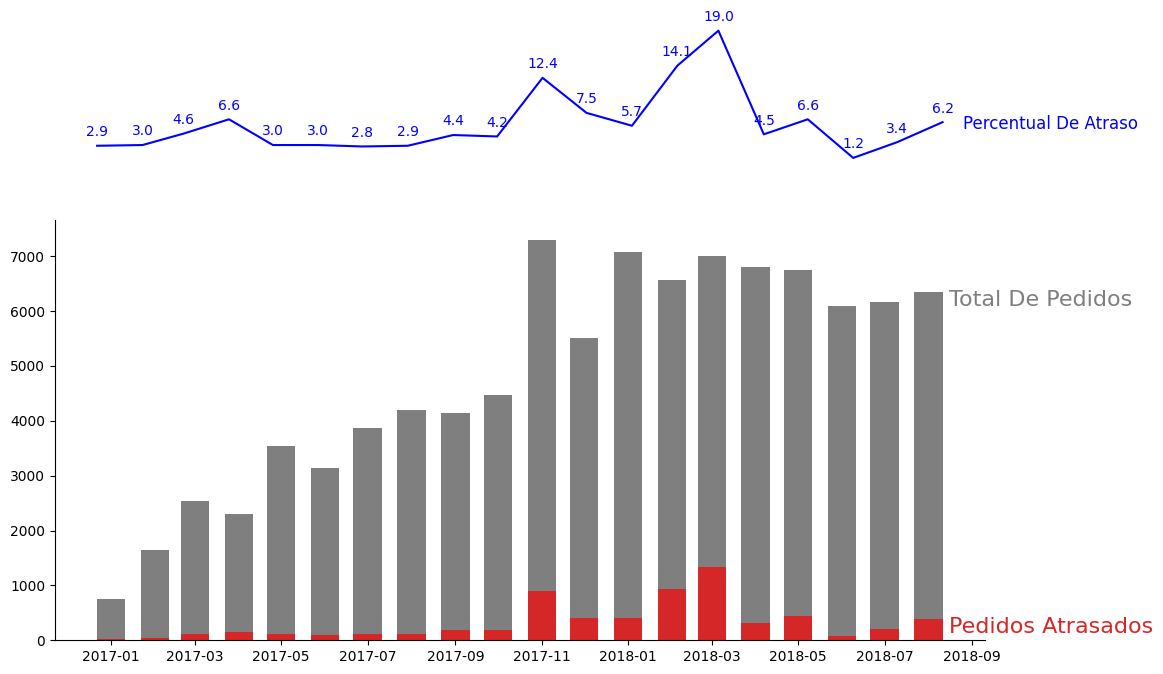

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(12,8), gridspec_kw={'height_ratios': [1, 3]})

ax[1].bar(contagem_pedidos.index.to_timestamp(), contagem_pedidos.values, width=20, color='tab:gray')
ax[1].bar(pedidos_atrasados.index.to_timestamp(), pedidos_atrasados.values, width=20, color='tab:red')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].annotate('Total De Pedidos', (contagem_pedidos.index.to_timestamp()[-1], contagem_pedidos.values[-1]),
                ha='left', xytext=(15,-10), textcoords='offset points', c='tab:gray', fontsize=16)
ax[1].annotate('Pedidos Atrasados', (pedidos_atrasados.index.to_timestamp()[-1], pedidos_atrasados.values[-1]),
                ha='left', xytext=(15,-10), textcoords='offset points', c='tab:red', fontsize=16)

ax[0].plot(percentual.index.to_timestamp(), percentual.values, c='b')

for i in range(0, len(percentual)):
    ax[0].annotate(percentual.values[i], (percentual.index.to_timestamp()[i], percentual.values[i]),
                    ha='center', xytext=(0,7), textcoords='offset points', c='b')
    
ax[0].annotate('Percentual De Atraso', (percentual.index.to_timestamp()[-1], percentual.values[-1]),
                ha='left', xytext=(15,-5), textcoords='offset points', c='b', fontsize=12)
    
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)

plt.show()

#### Concluímos que o atraso em alguns meses é enorme e totalmente desproporcional, isso deve ser investigado junto ao negócio

#### Vamos analisar agora a relação entre as avaliações e o atraso dos pedidos

In [25]:
#Visualizando tabela de avaliações
avaliacoes = executa_consulta('SELECT * FROM order_reviews')

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24


In [26]:
#Visualizando o percentual de avaliações por nota
round((avaliacoes.review_score.value_counts().sort_index()/avaliacoes.shape[0])*100,1)

1    11.5
2     3.2
3     8.2
4    19.3
5    57.8
Name: review_score, dtype: float64

In [34]:
#Juntando as tabelas avaliações e pedidos retirando os valores vazios das avaliações
avaliacoes_pedidos = executa_consulta('SELECT o.order_id, \
                                    o.order_purchase_timestamp, \
                                    o.order_delivered_customer_date, \
                                    o.order_estimated_delivery_date, \
                                    ROUND(AVG(ore.review_score), 1) as media_nota, \
                                    ROUND(MAX(ore.review_score), 1) as max_nota \
                                    FROM orders o \
                                    LEFT JOIN order_reviews ore \
                                    ON o.order_id = ore.order_id \
                                    WHERE ore.review_score IS NOT NULL \
                                    GROUP BY o.order_id, \
                                    o.order_purchase_timestamp, \
                                    o.order_delivered_customer_date, \
                                    o.order_estimated_delivery_date')

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,media_nota,max_nota
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,5.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15 00:00:00,4.0,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05 00:00:00,5.0,5.0


In [35]:
#Transformando as colunas necessárias em data
datas = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in datas:
    avaliacoes_pedidos[i] = pd.to_datetime(avaliacoes_pedidos[i], format='%Y-%m-%d %H:%M:%S')

#### Existem pedidos com mais de uma avaliação, será necessário uma avaliação do negócio de como proceder. Mas aqui vamos fazer uma análise para utilizar a média ou o máximo

In [36]:
#Verificando se faria ou não diferença utilizar um dos dois
avaliacoes_pedidos.groupby(['media_nota', 'max_nota'])['order_id'].count()

media_nota  max_nota
1.0         1.0         11316
1.5         2.0             8
2.0         2.0          3113
            3.0            12
2.5         3.0            10
            4.0            24
3.0         3.0          8094
            4.0             9
            5.0            33
3.3         4.0             1
3.5         4.0            17
            5.0             8
4.0         4.0         18993
            5.0            25
4.3         5.0             1
4.5         5.0            54
5.0         5.0         56955
Name: order_id, dtype: int64

In [37]:
#Retirando os casos onde o máximo e a média são iguais
avaliacoes_pedidos[avaliacoes_pedidos.media_nota != avaliacoes_pedidos.max_nota].groupby(['media_nota', 'max_nota'])['order_id'].count()

media_nota  max_nota
1.5         2.0          8
2.0         3.0         12
2.5         3.0         10
            4.0         24
3.0         4.0          9
            5.0         33
3.3         4.0          1
3.5         4.0         17
            5.0          8
4.0         5.0         25
4.3         5.0          1
4.5         5.0         54
Name: order_id, dtype: int64

In [38]:
#Verificando a proporção de registros onde a nota máxima e nota média são diferentes
avaliacoes_pedidos[avaliacoes_pedidos.media_nota != avaliacoes_pedidos.max_nota].shape[0]/avaliacoes_pedidos.shape[0]

0.002047165891378594

#### Nesse caso, a diferença é muito pequena então vamos utilizar a nota máxima, pois a média possui notas quebradas e não queremos isso.

In [39]:
#Criando uma coluna para a nota e deletando as de média e máximo para evitar confusão
avaliacoes_pedidos['nota'] = avaliacoes_pedidos.max_nota
avaliacoes_pedidos = avaliacoes_pedidos.drop(['media_nota', 'max_nota'], axis=1)

In [40]:
#Calculando a diferença dos dias de entregas dos pedidos
avaliacoes_pedidos['dias_atraso'] = (avaliacoes_pedidos.order_estimated_delivery_date.dt.date - avaliacoes_pedidos.order_delivered_customer_date.dt.date).dt.days

In [41]:
#Definindo se houve ou não atraso
avaliacoes_pedidos['atraso'] = avaliacoes_pedidos.dias_atraso.apply(lambda x: 1 if x < 0 else 0)

In [42]:
#Verificando a média das notas quando um pedido atrasa e quando não atrasa
avaliacoes_pedidos.groupby('atraso')['nota'].mean()

atraso
0    4.214376
1    2.274052
Name: nota, dtype: float64

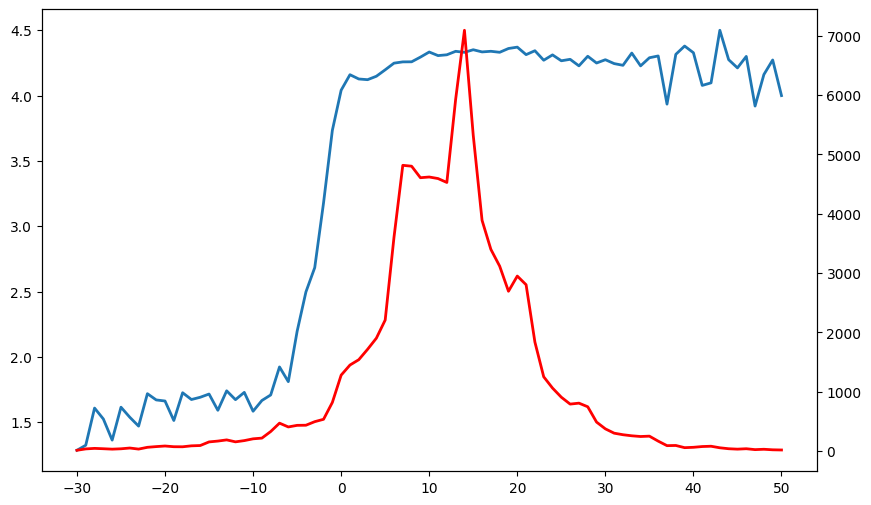

In [43]:
#Analisando visualmente a relação entre dias de atraso e notas
fig, ax = plt.subplots(figsize=(10,6))

base2 = avaliacoes_pedidos[(avaliacoes_pedidos.dias_atraso >= -30) & (avaliacoes_pedidos.dias_atraso <= 50)]

media_notas = base2.groupby('dias_atraso')['nota'].mean()
qtd_avaliacoes = base2.groupby('dias_atraso')['nota'].count()

ax2 = ax.twinx()

ax.plot(media_notas.index, media_notas.values, linewidth=2.0)
ax2.plot(qtd_avaliacoes.index, qtd_avaliacoes.values, linewidth=2.0, c='r')


plt.show()

#### Podemos ver que existe uma tendência onde quando mais demoramos a entregar menor é a nota da avaliação

In [44]:
#Alguns dias tem poucas amostras, então vamos agrupar os dias de atraso
def agrupa_atraso(dias_atraso):
        if dias_atraso < -20:
            return '01. Mais de 20 dias de atraso'
        elif dias_atraso < -15:
            return '02. Entre 15 e 20 dias de atraso'
        elif dias_atraso < -10:
            return '03. Entre 10 e 15 dias de atraso'
        elif dias_atraso < -8:
            return '04. Entre 8 e 10 dias de atraso'
        elif dias_atraso < -6:
            return '05. Entre 6 e 8 dias de atraso'
        elif dias_atraso < -4:
            return '06. Entre 4 e 6 dias de atraso'
        elif dias_atraso < -2:
            return '07. Entre 2 e 4 dias de atraso'
        elif dias_atraso < 0:
            return '08. Entre 1 e 2 dias de atraso'
        elif dias_atraso == 0:
            return '09. Entregue na data'
        elif dias_atraso <= 2:
            return '10. Entre 0 e 2 dias antes do prazo'
        elif dias_atraso <= 4:
            return '11. Entre 2 e 4 dias antes do prazo'
        elif dias_atraso <= 6:
            return '12. Entre 4 e 6 dias antes do prazo'
        elif dias_atraso <= 8:
            return '13. Entre 6 e 8 dias antes do prazo'
        elif dias_atraso <= 10:
            return '14. Entre 8 e 10 dias antes do prazo'
        elif dias_atraso <= 15:
            return '15. Entre 10 e 15 dias antes do prazo'
        elif dias_atraso <= 20:
            return '16. Entre 15 e 20 dias antes do prazo'
        elif dias_atraso <= 30:
            return '17. Entre 20 e 30 dias antes do prazo'
        elif dias_atraso <= 40:
            return '18. Entre 30 e 40 dias antes do prazo'
        elif dias_atraso > 40:
            return '19. Mais de 40 dias antes do prazo'
        else:
            return '20. Verificar'

In [45]:
#Aplicando a função na tabela
avaliacoes_pedidos['grupo_atraso'] = avaliacoes_pedidos.dias_atraso.apply(agrupa_atraso)

In [46]:
#Verificando o que aconteceu com os pedidos que estão para verificar
avaliacoes_pedidos[avaliacoes_pedidos.grupo_atraso == '20. Verificar']

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,dias_atraso,atraso,grupo_atraso
24,0010dedd556712d7bb69a19cb7bbd37a,2017-10-21 19:32:06,NaT,2017-11-03,1.0,NaN,0,20. Verificar
72,002f19a65a2ddd70a090297872e6d64e,2018-03-21 13:05:30,NaT,2018-04-16,3.0,NaN,0,20. Verificar
76,00310b0c75bb13015ec4d82d341865a4,2018-08-15 14:29:08,NaT,2018-08-29,1.0,NaN,0,20. Verificar
227,00a500bc03bc4ec968e574c2553bed4b,2017-11-23 10:53:01,NaT,2018-01-08,2.0,NaN,0,20. Verificar
233,00a99c50fdff7e36262caba33821875a,2018-08-17 16:25:04,NaT,2018-09-18,5.0,NaN,0,20. Verificar
...,...,...,...,...,...,...,...,...
98324,ff0768e3356919b32e3d7f30baecfcfb,2018-04-04 22:58:39,NaT,2018-04-23,1.0,NaN,0,20. Verificar
98396,ff358345576214cc9e08488188973c84,2018-03-03 17:05:12,NaT,2018-04-02,1.0,NaN,0,20. Verificar
98437,ff536d93ae4214b4d51c2894ccfc569f,2017-12-21 09:01:00,NaT,2018-01-10,3.0,NaN,0,20. Verificar
98471,ff7140ba310a4717112d39c0cd0b4062,2017-05-19 18:11:21,NaT,2017-06-26,1.0,NaN,0,20. Verificar


#### São os pedidos que não foram entregues. Vamos retirar da análise

In [47]:
avaliacoes_pedidos = avaliacoes_pedidos[avaliacoes_pedidos.grupo_atraso != '20. Verificar']

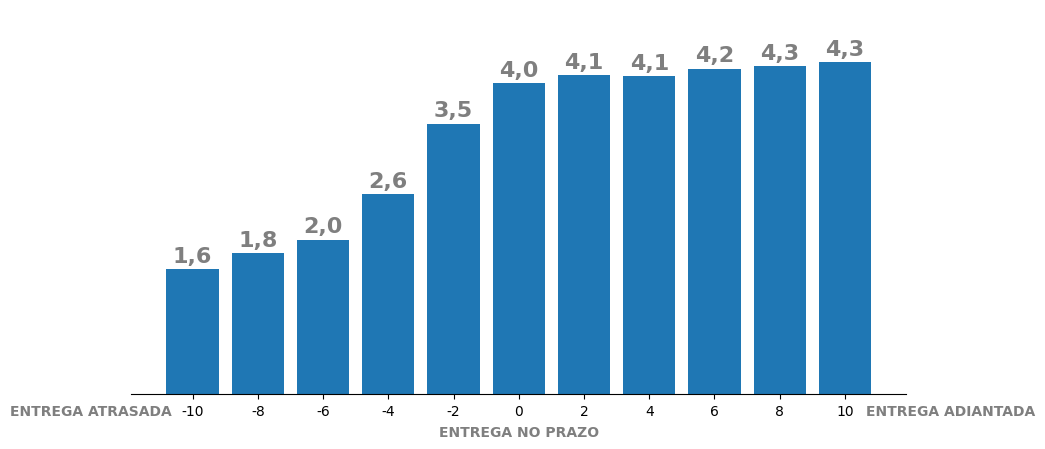

In [52]:
base_nova = avaliacoes_pedidos[(avaliacoes_pedidos.dias_atraso >= -10) & (avaliacoes_pedidos.dias_atraso <= 10)]
valores_grafico = base_nova.groupby('grupo_atraso')['nota'].mean()
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(valores_grafico.index, valores_grafico.values, linewidth=2.0,color='tab:blue')
    
for i in range(0,len(valores_grafico)):
    ax.annotate('{:.1f}'.format(valores_grafico.values[i]).replace('.',','),
                (valores_grafico.index[i],valores_grafico.values[i]),
                 ha='center', xytext=(0,5), textcoords='offset points',
                 fontsize=16,fontweight='bold',c='tab:gray')
    
ax.set_yticks([0,5])
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set(xticks=np.arange(0,len(valores_grafico)),xticklabels=[-10,-8,-6,-4,-2,0,2,4,6,8,10])

ax.annotate('ENTREGA NO PRAZO', (valores_grafico.index[5],0),
            ha='center', xytext=(0,-30), textcoords='offset points',
            fontsize=10, fontweight='bold', c='tab:gray')
ax.annotate('ENTREGA ATRASADA', (valores_grafico.index[0],0),
            ha='right', xytext=(-15,-15), textcoords='offset points',
            fontsize=10, fontweight='bold', c='tab:gray')
ax.annotate('ENTREGA ADIANTADA', (valores_grafico.index[-1],0),
             ha='left', xytext=(+15,-15), textcoords='offset points',
            fontsize=10, fontweight='bold', c='tab:gray')

plt.show()

#### Com essa visualização podemos ver claramente que existe uma correlação entre as notas e o atraso na entrega

#### Por fim, vamos fazer uma análise dos comentários

In [53]:
#Visualizando base tratada
base_nova.head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,dias_atraso,atraso,grupo_atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,9.0,0,14. Entre 8 e 10 dias antes do prazo
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,3.0,0,11. Entre 2 e 4 dias antes do prazo
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0,6.0,0,12. Entre 4 e 6 dias antes do prazo


In [57]:
#Filtrando para ver somente as linhas entre 10 e 5 dias de atraso
base_nova[base_nova.dias_atraso <= -5].head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,dias_atraso,atraso,grupo_atraso
42,001c85b5f68d2be0cb0797afc9e8ce9a,2017-11-24 19:19:18,2017-12-22 18:37:40,2017-12-14,2.0,-8.0,1,05. Entre 6 e 8 dias de atraso
93,003a94f778ef8cfd50247c8c1b582257,2018-08-03 14:52:31,2018-08-24 00:18:38,2018-08-15,1.0,-9.0,1,04. Entre 8 e 10 dias de atraso
99,003f201cdd39cdd59b6447cff2195456,2018-02-21 16:59:24,2018-03-28 18:54:53,2018-03-22,1.0,-6.0,1,06. Entre 4 e 6 dias de atraso


In [58]:
#Pegando ids entre 10 e 5 dias de atraso
ids = base_nova.loc[base_nova.dias_atraso <= -5, 'order_id']

In [59]:
#Filtrando para ver apenas as avaliações de 10 e 5 dias de atraso
avaliacoes[avaliacoes.order_id.isin(ids)].head(3)

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
32,32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,None,Sempre compro pela Internet e a entrega ocorre...,2018-04-08 00:00:00,2018-04-09 12:22:39
39,39,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,None,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03
45,45,3dc0777d97733a1d066f5b781e91577f,44a9994228432b835c3a4e720b6a41ab,4,None,None,2018-03-29 00:00:00,2018-03-31 00:13:07


In [60]:
#Vendo somente os comentários desses ids
avaliacoes.loc[avaliacoes.order_id.isin(ids), 'review_comment_message']

32       Sempre compro pela Internet e a entrega ocorre...
39                            Nada de chegar o meu pedido.
45                                                    None
106                                                   None
168      Comprei o produto dia 25 de fevereiro e hoje d...
                               ...                        
99091                          Ainda nao recevi o produto.
99094    Gostaria de saber porque meu produto ainda não...
99098                                muito bom! recomendo!
99144                                                 None
99174                                                 None
Name: review_comment_message, Length: 2078, dtype: object

#### Para a análise vamos criar uma nuvem de palavras

In [63]:
#Tirando os espaços para que a nuvem de palavras sejam frases para uma melhor análise
texto = ''

for i in avaliacoes.loc[avaliacoes.order_id.isin(ids), 'review_comment_message']:
    if i:
        i = i.replace(' ','')
        texto += i
        texto += ' '

In [64]:
#Retirando palavras que são muito usadas mas não trazem valor
wordcloud = WordCloud(stopwords=['o', 'e', 'de', 'produto', 'eu', 'em', 'que', 'Bomdia']).generate(texto)

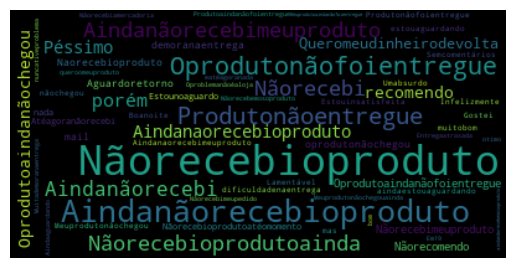

In [65]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('NuvemPalavras', bbox_inches='tight', transparent=True)

### Conclusões:
- Existe um problema real de atraso na entrega de pedidos
- Esses atrasos causam uma avaliação baixa para a empresa
- A maioria dos comentários são sobre reclamações de atraso
- Claro que um produto ou outro pode atrasar, mas isso não pode ser recorrente e algo deve ser feito para minimizar a dor do cliente quando o atraso é inevitável